In [1]:
!nvidia-smi

Sat Feb 14 22:25:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Sequential
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import (
    Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D, Input,
    RandomFlip, RandomRotation, RandomZoom,RandomContrast
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report, f1_score
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

2026-02-14 22:25:50.437275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771107950.573095     833 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771107950.614697     833 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771107950.964495     833 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771107950.964534     833 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771107950.964537     833 computation_placer.cc:177] computation placer alr

In [3]:
import os

base_path = "/kaggle/working/rice_data/Rice_Leaf_Diease/train"  

for folder in os.listdir(base_path):
    old_path = os.path.join(base_path, folder)

    if os.path.isdir(old_path):
        # lowercase + replace spaces with underscore
        new_name = folder.lower().replace(" ", "_")
        new_path = os.path.join(base_path, new_name)

        if old_path != new_path:
            os.rename(old_path, new_path)
            print(f"Renamed: {folder} ➜ {new_name}")

print("✅ Folder renaming completed.")


✅ Folder renaming completed.


In [4]:
import os

base_path = "/kaggle/working/rice_data/Rice_Leaf_Diease/test"

for folder in os.listdir(base_path):
    old_path = os.path.join(base_path, folder)

    if os.path.isdir(old_path):
        # lowercase + replace spaces with underscore
        new_name = folder.lower().replace(" ", "_")
        new_path = os.path.join(base_path, new_name)

        if old_path != new_path:
            os.rename(old_path, new_path)
            print(f"Renamed: {folder} ➜ {new_name}")

print("✅ Folder renaming completed.")


✅ Folder renaming completed.


In [5]:
training_set = image_dataset_from_directory(
    '/kaggle/working/rice_data/Rice_Leaf_Diease/train',
    image_size=(224, 224),
    batch_size=32,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 15023 files belonging to 10 classes.


I0000 00:00:1771107958.221074     833 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771107958.226977     833 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
validation_set = image_dataset_from_directory(
    '/kaggle/working/rice_data/Rice_Leaf_Diease/test',
    image_size=(224, 224),
    batch_size=32,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=0.5,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3422 files belonging to 10 classes.
Using 1711 files for training.


In [7]:
test_set = image_dataset_from_directory(
    '/kaggle/working/rice_data/Rice_Leaf_Diease/test',
    image_size=(224, 224),
    batch_size=32,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=0.5,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3422 files belonging to 10 classes.
Using 1711 files for validation.


In [8]:
class_names = training_set.class_names
print(class_names)

['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


In [9]:
print(training_set)
print(validation_set)
print(test_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [10]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=AUTOTUNE)
test_set = test_set.prefetch(buffer_size=AUTOTUNE)

In [12]:
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))

#Block 0
x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x)

#Block 1
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
#Block 2
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
#Block 3
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
#Block 4
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
#Block 5
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
#Block 6
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)



outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs, name="EfficientNetB3_Plant_Disease_Classifier")  


In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
model.build(input_shape=(None, 224, 224, 3))

In [15]:
model.summary()

Model: "EfficientNetB3_Plant_Disease_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,755,481 (44.84 MB)

 Trainable params: 6,017,054 (22.95 MB)

 Non-trainable params: 5,738,427 (21.89 MB)

In [16]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'Rice_Model_Weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

In [17]:
training_history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


E0000 00:00:1771107985.723867     833 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetB3_Plant_Disease_Classifier_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1771108055.592292     900 cuda_dnn.cc:529] Loaded cuDNN version 91002


470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5326 - loss: 1.4597
Epoch 1: val_accuracy improved from -inf to 0.90999, saving model to Rice_Model_Weights.h5


470/470 ━━━━━━━━━━━━━━━━━━━━ 189s 202ms/step - accuracy: 0.5329 - loss: 1.4586 - val_accuracy: 0.9100 - val_loss: 0.3078 - learning_rate: 0.0010
Epoch 2/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8537 - loss: 0.4642
Epoch 2: val_accuracy improved from 0.90999 to 0.95383, saving model to Rice_Model_Weights.h5


470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 188ms/step - accuracy: 0.8537 - loss: 0.4641 - val_accuracy: 0.9538 - val_loss: 0.1324 - learning_rate: 0.0010
Epoch 3/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8976 - loss: 0.3338
Epoch 3: val_accuracy did not improve from 0.95383
470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 186ms/step - accuracy: 0.8976 - loss: 0.3337 - val_accuracy: 0.9439 - val_loss: 0.1577 - learning_rate: 0.0010
Epoch 4/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9172 - loss: 0.2704
Epoch 4: val_accuracy improved from 0.95383 to 0.96318, saving model to Rice_Model_Weights.h5


470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 188ms/step - accuracy: 0.9172 - loss: 0.2703 - val_accuracy: 0.9632 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 5/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9339 - loss: 0.2200
Epoch 5: val_accuracy improved from 0.96318 to 0.96493, saving model to Rice_Model_Weights.h5


470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 188ms/step - accuracy: 0.9339 - loss: 0.2200 - val_accuracy: 0.9649 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 6/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9340 - loss: 0.2145
Epoch 6: val_accuracy improved from 0.96493 to 0.97954, saving model to Rice_Model_Weights.h5


470/470 ━━━━━━━━━━━━━━━━━━━━ 141s 189ms/step - accuracy: 0.9340 - loss: 0.2145 - val_accuracy: 0.9795 - val_loss: 0.0696 - learning_rate: 0.0010
Epoch 7/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9498 - loss: 0.1655
Epoch 7: val_accuracy did not improve from 0.97954
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 186ms/step - accuracy: 0.9498 - loss: 0.1655 - val_accuracy: 0.9696 - val_loss: 0.0934 - learning_rate: 0.0010
Epoch 8/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9543 - loss: 0.1531
Epoch 8: val_accuracy did not improve from 0.97954
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 187ms/step - accuracy: 0.9543 - loss: 0.1530 - val_accuracy: 0.9679 - val_loss: 0.1183 - learning_rate: 0.0010
Epoch 9/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9640 - loss: 0.1282
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_accuracy did not improve from 0.97954
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 187ms/step - accuracy: 0.9640 - loss:

470/470 ━━━━━━━━━━━━━━━━━━━━ 141s 190ms/step - accuracy: 0.9712 - loss: 0.0983 - val_accuracy: 0.9906 - val_loss: 0.0305 - learning_rate: 5.0000e-04
Epoch 11/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9789 - loss: 0.0716
Epoch 11: val_accuracy did not improve from 0.99065
470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 187ms/step - accuracy: 0.9789 - loss: 0.0716 - val_accuracy: 0.9895 - val_loss: 0.0268 - learning_rate: 5.0000e-04
Epoch 12/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9769 - loss: 0.0747
Epoch 12: val_accuracy improved from 0.99065 to 0.99299, saving model to Rice_Model_Weights.h5


470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 189ms/step - accuracy: 0.9769 - loss: 0.0747 - val_accuracy: 0.9930 - val_loss: 0.0262 - learning_rate: 5.0000e-04
Epoch 13/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9812 - loss: 0.0676
Epoch 13: val_accuracy did not improve from 0.99299
470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 187ms/step - accuracy: 0.9812 - loss: 0.0676 - val_accuracy: 0.9889 - val_loss: 0.0381 - learning_rate: 5.0000e-04
Epoch 14/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9810 - loss: 0.0641
Epoch 14: val_accuracy improved from 0.99299 to 0.99357, saving model to Rice_Model_Weights.h5


470/470 ━━━━━━━━━━━━━━━━━━━━ 141s 189ms/step - accuracy: 0.9810 - loss: 0.0641 - val_accuracy: 0.9936 - val_loss: 0.0266 - learning_rate: 5.0000e-04
Epoch 15/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9838 - loss: 0.0529
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: val_accuracy did not improve from 0.99357
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 186ms/step - accuracy: 0.9838 - loss: 0.0529 - val_accuracy: 0.9906 - val_loss: 0.0435 - learning_rate: 5.0000e-04
Epoch 16/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9871 - loss: 0.0473
Epoch 16: val_accuracy did not improve from 0.99357
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 186ms/step - accuracy: 0.9871 - loss: 0.0473 - val_accuracy: 0.9918 - val_loss: 0.0321 - learning_rate: 2.5000e-04
Epoch 17/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9885 - loss: 0.0393
Epoch 17: val_accuracy did not improve from 0.99357
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 186ms/step - accur

470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 189ms/step - accuracy: 0.9932 - loss: 0.0254 - val_accuracy: 0.9953 - val_loss: 0.0185 - learning_rate: 1.2500e-04
Epoch 22/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9947 - loss: 0.0187
Epoch 22: val_accuracy did not improve from 0.99532
470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 186ms/step - accuracy: 0.9947 - loss: 0.0187 - val_accuracy: 0.9924 - val_loss: 0.0269 - learning_rate: 1.2500e-04
Epoch 23/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9936 - loss: 0.0197
Epoch 23: val_accuracy did not improve from 0.99532
470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 187ms/step - accuracy: 0.9936 - loss: 0.0197 - val_accuracy: 0.9947 - val_loss: 0.0244 - learning_rate: 1.2500e-04
Epoch 24/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9933 - loss: 0.0215
Epoch 24: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 24: val_accuracy did not improve from 0.99532
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 186ms/step - accura

470/470 ━━━━━━━━━━━━━━━━━━━━ 140s 188ms/step - accuracy: 0.9960 - loss: 0.0153 - val_accuracy: 0.9965 - val_loss: 0.0145 - learning_rate: 6.2500e-05
Epoch 28/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9969 - loss: 0.0121
Epoch 28: val_accuracy did not improve from 0.99649
470/470 ━━━━━━━━━━━━━━━━━━━━ 138s 186ms/step - accuracy: 0.9969 - loss: 0.0121 - val_accuracy: 0.9930 - val_loss: 0.0244 - learning_rate: 6.2500e-05
Epoch 29/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9966 - loss: 0.0130
Epoch 29: val_accuracy did not improve from 0.99649
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 186ms/step - accuracy: 0.9966 - loss: 0.0130 - val_accuracy: 0.9953 - val_loss: 0.0180 - learning_rate: 6.2500e-05
Epoch 30/30
470/470 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9964 - loss: 0.0136
Epoch 30: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 30: val_accuracy did not improve from 0.99649
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 186ms/step - accur

In [18]:
training_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


📈 Training history:



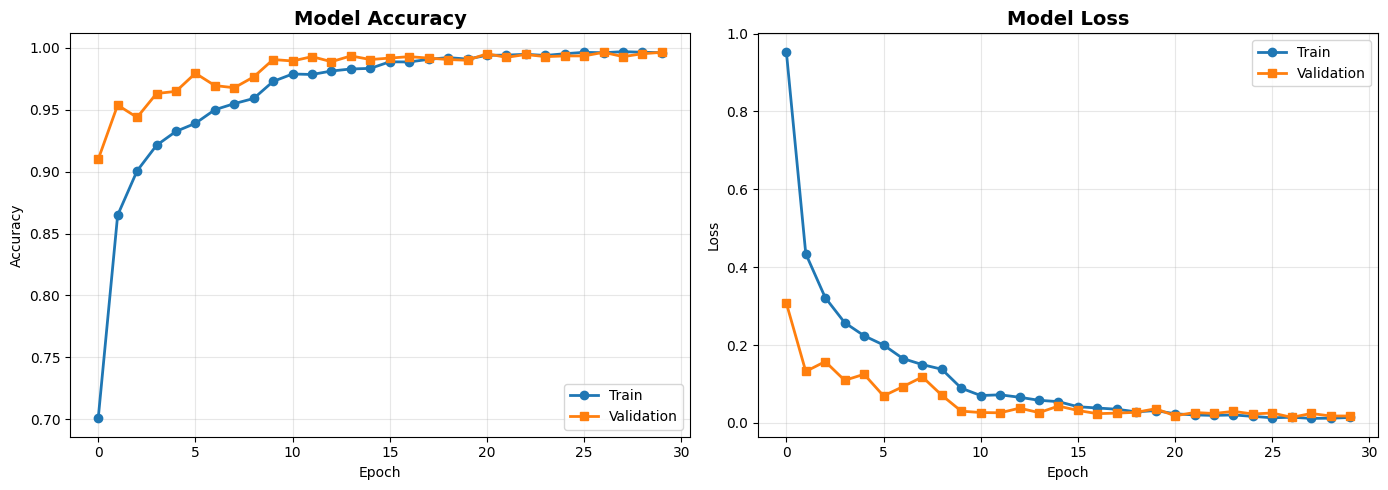


📊 FINAL METRICS:
   Best Train Accuracy: 0.9970 (99.70%)
   Best Val Accuracy: 0.9965 (99.65%)
   Best Val Loss: 0.0145
   Target ≥98.5%: ACHIEVED ✅


In [19]:
print("\n📈 Training history:\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(training_history.history['accuracy'], label='Train', linewidth=2, marker='o')
axes[0].plot(training_history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(training_history.history['loss'], label='Train', linewidth=2, marker='o')
axes[1].plot(training_history.history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Model_acc_model_loss.png', dpi=800)
plt.show()


# Final metrics
best_val_acc = max(training_history.history['val_accuracy'])
best_train_acc = max(training_history.history['accuracy'])
final_val_loss = min(training_history.history['val_loss'])

print(f"\n📊 FINAL METRICS:")
print(f"   Best Train Accuracy: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"   Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Best Val Loss: {final_val_loss:.4f}")
print(f"   Target ≥98.5%: {'ACHIEVED ✅' if best_val_acc >= 0.985 else 'IN PROGRESS ⏳'}")

In [20]:
print(max(training_history.history['accuracy']))
print(max(training_history.history['val_accuracy']))
print(min(training_history.history['loss']))
print(min(training_history.history['val_loss']))

0.9970045685768127
0.9964932799339294
0.011819317936897278
0.014460827223956585



📊 Evaluating model on Validation...

54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step
📋 CLASSIFICATION REPORT (VALIDATION)
                       precision    recall  f1-score   support

bacterial_leaf_blight     1.0000    1.0000    1.0000       188
           brown_spot     1.0000    0.9733    0.9864       187
              healthy     1.0000    1.0000    1.0000       205
           leaf_blast     0.9890    0.9944    0.9917       180
           leaf_scald     1.0000    1.0000    1.0000       189
    narrow_brown_spot     0.9788    1.0000    0.9893       185
           neck_blast     1.0000    1.0000    1.0000       161
           rice_hispa     1.0000    1.0000    1.0000       117
        sheath_blight     1.0000    1.0000    1.0000       148
               tungro     1.0000    1.0000    1.0000       151

             accuracy                         0.9965      1711
            macro avg     0.9968    0.9968    0.9967      1711
         weighted avg     0.9965    0.9965    0.9965      1711

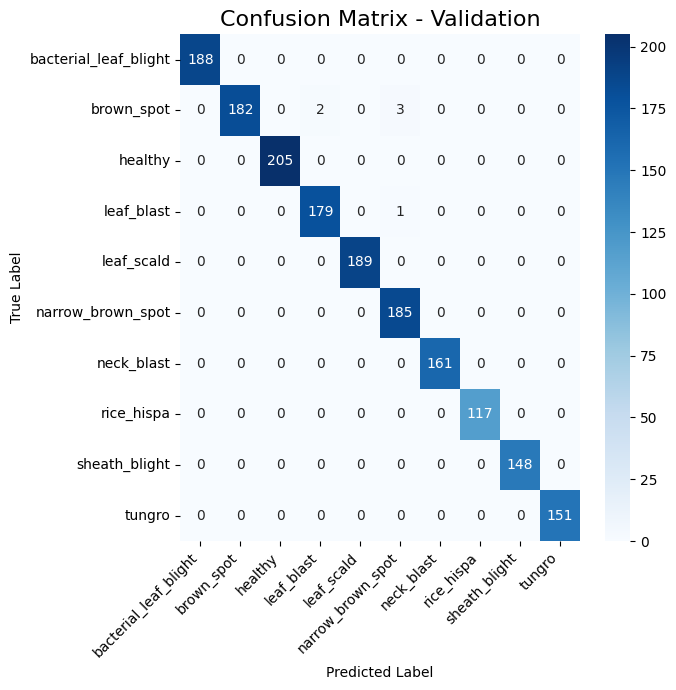


📊 Evaluating model on Test...

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step
📋 CLASSIFICATION REPORT (TEST)
                       precision    recall  f1-score   support

bacterial_leaf_blight     1.0000    1.0000    1.0000       188
           brown_spot     0.9894    0.9689    0.9791       193
              healthy     1.0000    1.0000    1.0000       186
           leaf_blast     1.0000    0.9890    0.9945       182
           leaf_scald     1.0000    1.0000    1.0000       197
    narrow_brown_spot     0.9704    1.0000    0.9850       197
           neck_blast     1.0000    1.0000    1.0000       161
           rice_hispa     1.0000    1.0000    1.0000       108
        sheath_blight     1.0000    1.0000    1.0000       140
               tungro     1.0000    1.0000    1.0000       159

             accuracy                         0.9953      1711
            macro avg     0.9960    0.9958    0.9959      1711
         weighted avg     0.9954    0.9953    0.9953      1711


🎯 Weighted

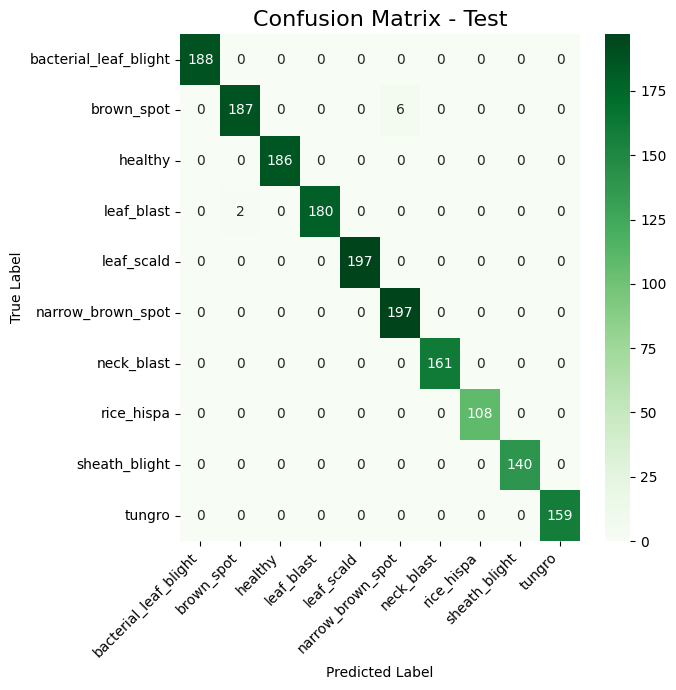


📊 FINAL SUMMARY

🔵 VALIDATION:
   Accuracy: 0.9965
   F1 Score: 0.9965

🟢 TEST:
   Accuracy: 0.9953
   F1 Score: 0.9953

Gap: 0.0012 ✅ Excellent generalization


In [31]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_dataset(model, dataset, class_names, dataset_name="Dataset", cmap="Blues"):
    print(f"\n📊 Evaluating model on {dataset_name}...\n")
    
    # --- 1. ROBUST EXTRACTION (The Fix) ---
    # We iterate ONCE to capture images and labels in perfect sync
    all_images = []
    all_labels = []
    
    for images, labels in dataset:
        all_images.append(images)
        all_labels.append(labels)
        
    # Concatenate batches into single tensors
    x_all = tf.concat(all_images, axis=0)
    y_all_one_hot = tf.concat(all_labels, axis=0)
    
    # --- 2. PREDICTION ---
    # Predict on the strictly ordered image tensor
    pred_probs = model.predict(x_all, verbose=1)
    
    # --- 3. DECODING (Handling Categorical Mode) ---
    y_pred = np.argmax(pred_probs, axis=1)        # Convert probs to [0, 1, 0...]
    y_true = np.argmax(y_all_one_hot, axis=1)     # Convert one-hot to [0, 1, 0...]

    # --- 4. METRICS & PLOTTING ---
    # Classification Report
    print("="*80)
    print(f"📋 CLASSIFICATION REPORT ({dataset_name.upper()})")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = np.mean(y_pred == y_true)

    print(f"\n🎯 Weighted F1 Score: {f1:.4f}")
    print(f"📊 Overall Accuracy:  {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig(f'confusion_matrix_{dataset_name.lower()}.png', dpi=300) # Optional save
    plt.show()

    return f1, acc

val_f1, val_acc = evaluate_dataset(model, validation_set, class_names, "Validation", "Blues")
test_f1, test_acc = evaluate_dataset(model, test_set, class_names, "Test", "Greens")


print("\n" + "="*80)
print("📊 FINAL SUMMARY")
print("="*80)

print(f"\n🔵 VALIDATION:")
print(f"   Accuracy: {val_acc:.4f}")
print(f"   F1 Score: {val_f1:.4f}")

print(f"\n🟢 TEST:")
print(f"   Accuracy: {test_acc:.4f}")
print(f"   F1 Score: {test_f1:.4f}")

gap = abs(val_f1 - test_f1)

if gap < 0.02:
    print(f"\nGap: {gap:.4f} ✅ Excellent generalization")
elif gap < 0.05:
    print(f"\nGap: {gap:.4f} ⚠️ Acceptable")
else:
    print(f"\nGap: {gap:.4f} ❌ Possible overfitting")

print("="*80)


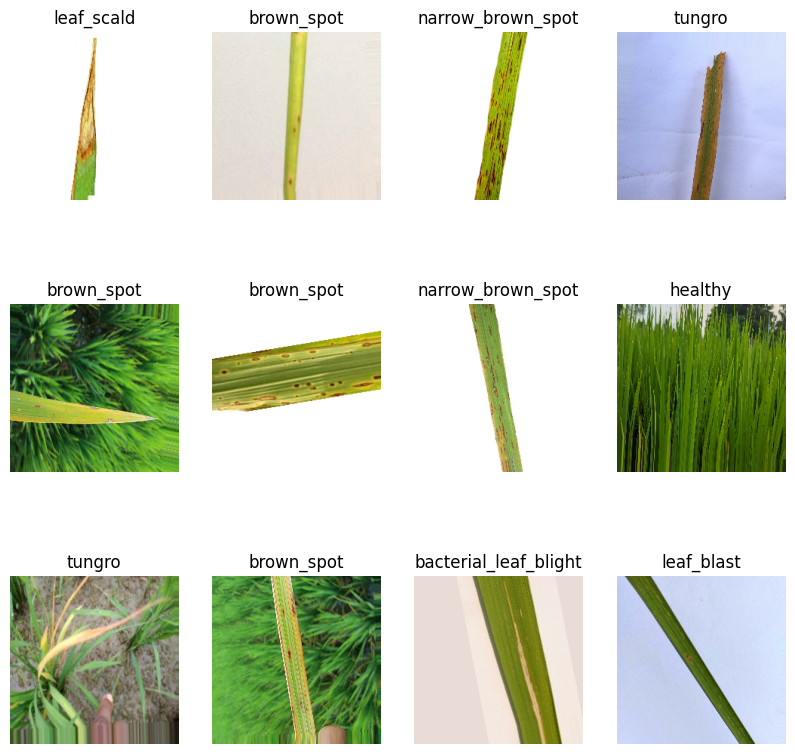

In [40]:
plt.figure(figsize=(10, 10))

# Take 1 batch from the dataset
for image_batch, labels_batch in training_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        
        # Display the image
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # FIX: Convert One-Hot Vector to Integer Index
        # If labels are [0, 1, 0], argmax returns 1 (the index of the max value)
        label_index = np.argmax(labels_batch[i])
        
        # Use the integer index to get the class name
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

first image to predict


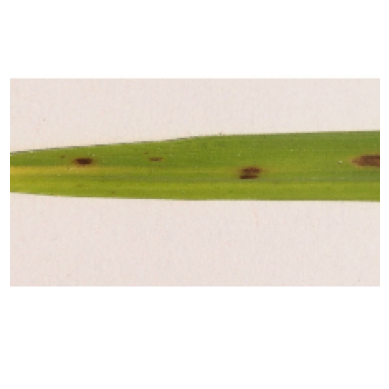

actual label: brown_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
predicted label: brown_spot


In [46]:
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()
    
    # FIX: Convert One-Hot vector to Integer Index
    actual_index = np.argmax(first_label)
    print("actual label:", class_names[actual_index])
    
    # Predict
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])
    
    # Break to prevent looping if the dataset is infinite
    break

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


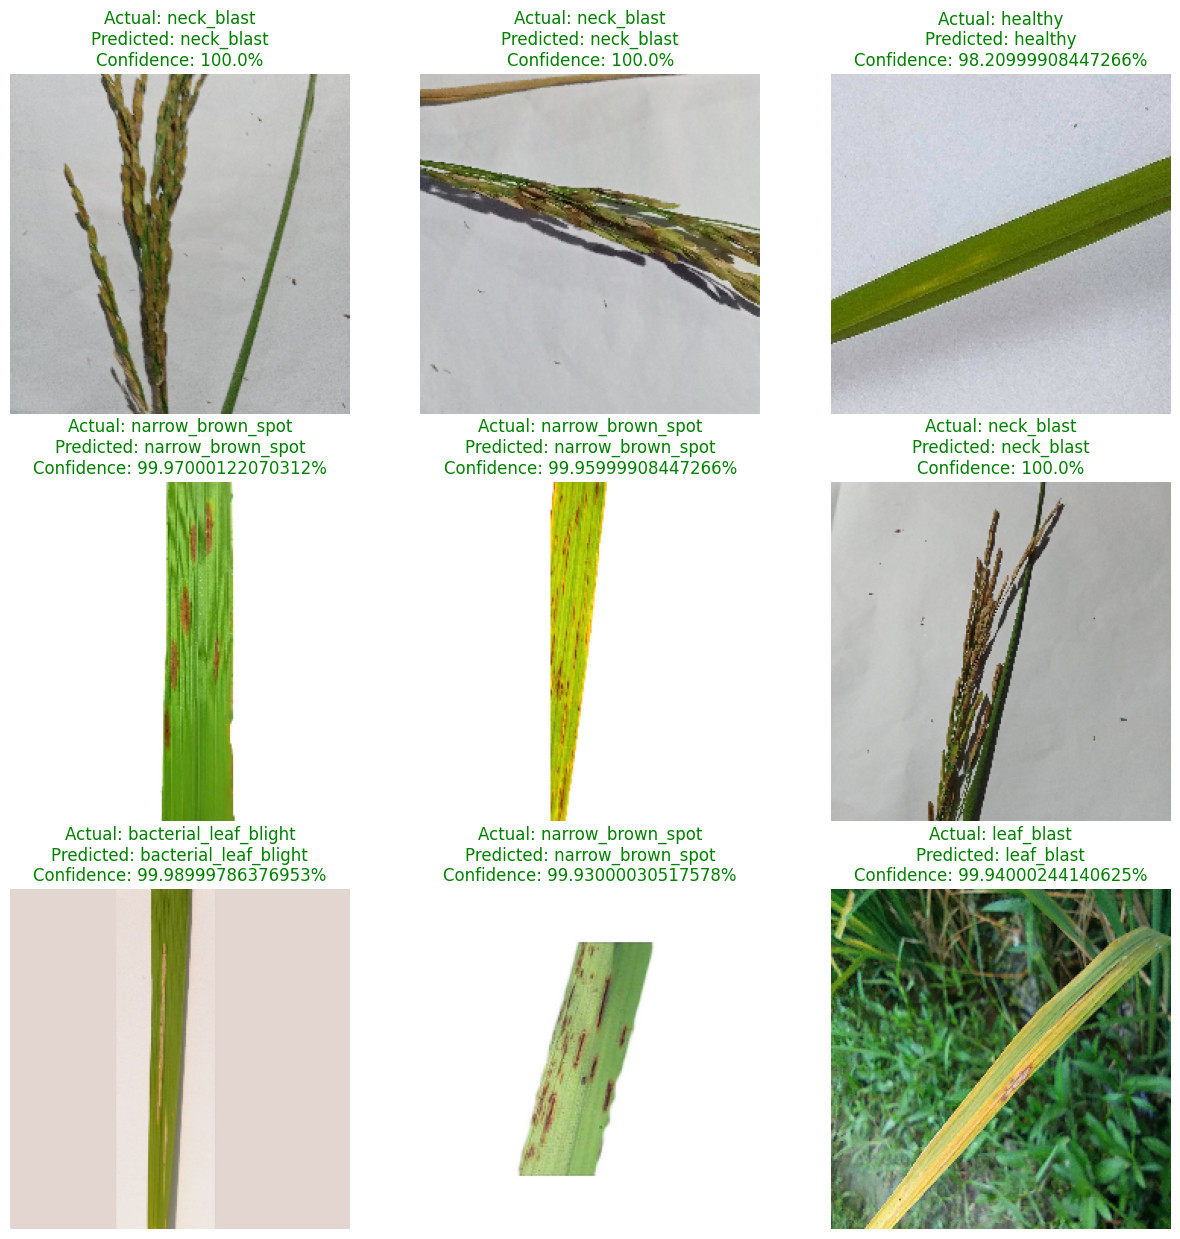

In [47]:
plt.figure(figsize=(15, 15))

# Take 1 batch from the test set
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Display image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Predict
        predicted_class, confidence = predict(model, images[i].numpy())
        
        # --- FIX: Convert One-Hot Label to Integer ---
        # labels[i] is [0, 1]. argmax converts it to 1.
        actual_index = np.argmax(labels[i])
        actual_class = class_names[actual_index] 
        
        # Color code the title (Green = Correct, Red = Wrong)
        color = 'green' if predicted_class == actual_class else 'red'
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", 
                  color=color)
        
        plt.axis("off")

plt.show()

In [32]:
model.save_weights('Rice___model_weights_final_vg.weights.h5')
model.save('Rice_custom_cnn_best_final_vg.keras')